In [24]:
%load_ext autoreload
%autoreload 3
%matplotlib inline

import numpy as np
import qiskit
import pennylane as qml
from vqa.transpiler.architectures import (
    FakeChalmers4,
    FakeChalmers6,
    FakeChalmers9,
    FakeChalmers20,
)
from vqa import transforms

from vqa.templates.examples import h2_vqe_circuit, BarrenPlateauCircuit
from vqa.transpiler import transpile_circuit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The quantum circuit before transpilation

In [25]:
circuit_ansatz = BarrenPlateauCircuit(num_layers=1, num_qubits=4)
# circuit_h2 = h2_vqe_circuit(num_layers=1)
params = circuit_ansatz.init()

print(params)

[2.46321494 4.19531499 1.33478504 3.1314761 ]


In [26]:
# circuit = transforms.exp_val(circuit, H=circuit.H, wires=circuit.wires)
dev = qml.device("default.qubit", wires=circuit_ansatz.wires)


@qml.qnode(dev)
def circuit(params):
    circuit_ansatz(params)
    return qml.expval(circuit_ansatz.H)


circuit = transforms.exp_val(circuit_ansatz)

In [27]:
qml.draw(circuit)(params)

'0: ──RY(0.79)──RX(2.46)─╭||─╭●────╭Z─╭||─┤ ╭<𝓗(1.00)>\n1: ──RY(0.79)──RZ(4.20)─├||─╰Z─╭●─│──├||─┤ ╰<𝓗(1.00)>\n2: ──RY(0.79)──RZ(1.33)─├||─╭●─╰Z─│──├||─┤           \n3: ──RY(0.79)──RY(3.13)─╰||─╰Z────╰●─╰||─┤           '

/Users/davidfitzek/miniforge3/envs/vqa/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/davidfitzek/miniforge3/envs/vqa/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


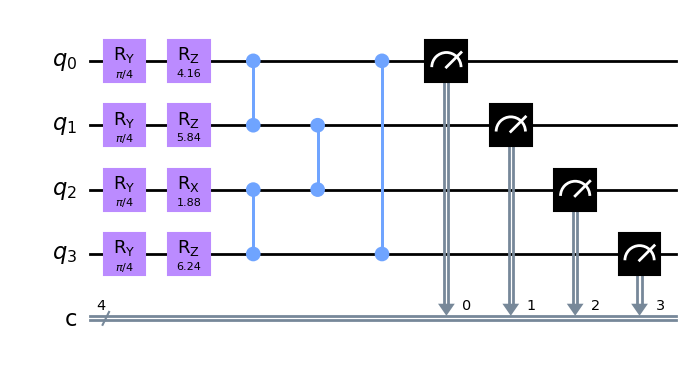

In [28]:
transforms.draw(circuit_ansatz)

# Transpiling the circuit to the chalmers hardware

In [29]:
backend = FakeChalmers9()

transpiled_circuit_ansatz = transpile_circuit(
    circuit_ansatz, backend=backend, params=params
)

In [30]:
# update circuit ansatz
circuit_ansatz.update_circuit_ansatz(transpiled_circuit_ansatz, backend.n_qubits)

In [31]:
circuit = transforms.exp_val(circuit_ansatz)
exp_val_after = circuit(params)

print(exp_val_after)

0.999999999999999


# Circuit specs 
Usually we are interested in the overall circuit depth of the quantum circuit.

In [32]:
qml.specs(circuit)(params)

{'gate_sizes': defaultdict(int, {1: 41, 2: 7}),
 'gate_types': defaultdict(int,
             {'RX': 16, 'RZ': 19, 'ISWAP': 7, 'Hadamard': 6}),
 'num_operations': 48,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 6,
 'depth': 15,
 'num_trainable_params': 4,
 'num_device_wires': 9,
 'device_name': 'default.qubit.autograd',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'autograd',
 'diff_method': 'best',
 'gradient_fn': 'backprop'}

In [33]:
# seesm to be buggy, even though the gate sequence indicates only ISwap gates it shows CNOts instead.

# transforms.draw(circuit_ansatz, params=params, wires=range(backend.n_qubits))

# dev = qml.device("qiskit.aer", wires=range(backend.n_qubits))

# @qml.qnode(dev)
# def _circuit(x):
#     transpiled_circuit_ansatz(x)
#     return qml.expval(circuit_ansatz.H)

# _circuit(params)  # Don't forget to run the circuit once for initialization.

# dev._circuit.draw(output="mpl")

In [34]:
print(qml.draw(circuit)(params))

0: ───────────────────────────────────────────────────────────────────────────────────────────
1: ───────────────────────────────────────────────────────────────────────────────────────────
4: ──RX(1.57)──RZ(0.79)──RX(-1.57)──RZ(2.46)──RZ(-1.87)───────────╭ISWAP──RZ(1.66)───RX(3.14)─
5: ──RX(1.57)──RZ(0.79)──RX(-1.57)──RX(4.20)──RZ(0.09)───RX(3.14)─╰ISWAP──RZ(-1.27)──RX(1.57)─
7: ──RX(1.57)──RZ(0.79)──RX(-1.57)──RZ(1.33)──RZ(3.14)──╭ISWAP─────H─────╭ISWAP──────RX(-1.57)
8: ──RX(1.57)──RZ(0.79)──RX(-1.57)──RZ(3.13)──H─────────╰ISWAP───────────╰ISWAP──────RZ(1.57)─

──────────────────────────────────────────────────────────────────────────────────────────┤ ╭<𝓗(1.00)>
──────────────────────────────────────────────────────────────────────────────────────────┤ ╰<𝓗(1.00)>
────────────╭ISWAP──H─╭ISWAP──RX(-3.14)──RZ(-1.57)────────────────────────────────────────┤           
───RZ(1.57)─│─────────│────────────────────────────╭ISWAP────╭ISWAP──H──────────RZ(1.57)──┤           
───RZ(1.57)─╰ISWA